# 1. Pre-processing Data

In [7]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
from PIL import Image,ImageFile

In [8]:
zip_data = 'data.zip'
zip_ref = zipfile.ZipFile(zip_data,'r')
zip_ref.extractall('data/') # Extract the filezip to 'data' folder
zip_ref.close()

In [9]:
# Get sum data of each class
labels = os.listdir('data') # get label name
source_path = 'data'
for label in labels:
    path_class = os.path.join(source_path,label)
    print('{} images of {}'.format(len(os.listdir(path_class)), label))

65 images of Koi Asagi
57 images of Koi Beni Kumonryu
60 images of Koi Doitsu Hariwake
65 images of Koi Goromo
64 images of Koi Kawarimono
58 images of Koi Kohaku
63 images of Koi Kujaku
62 images of Koi Shusui
60 images of Koi Taisho Sanke
60 images of Koi Tancho


In [10]:
# Convert jfif format file into jpg
for label in labels:
    label_path = os.path.join(source_path,label)
    for file in os.listdir(label_path):
        if file.endswith('.jfif'):
            image = Image.open(os.path.join(label_path,file))
            file_name, file_ext = os.path.splitext(file)
            image.save(label_path+'/{}.png'.format(file_name))
            os.remove(os.path.join(label_path,file))

In [11]:
# Create train,validation and test folder
root_path = 'dataset'

# Check if the folder exist
if os.path.exists(root_path):
    shutil.rmtree(root_path)

# Create train,validation and test folder
def create_train_val_test(root_path):
    folder_1 = ['train','validation','test']
    folder_2 = os.listdir('data')
    for sub1 in folder_1:
        for sub2 in folder_2:
            new_folder = os.path.join(root_path,sub1,sub2)
            os.makedirs(new_folder)

try:
    create_train_val_test(root_path=root_path)
except FileExistsError:
    print("The upper folder doesn't exist")

In [12]:
# Create split data function
def split_data(path_source,training_dir,val_dir,test_dir,split_size):
    files = []
    for file in os.listdir(path_source):
        if os.path.getsize(path_source+file) > 0 : # Check if there is a corrupt image
            files.append(file)
        else:
            print(file+'is zero size')
    
    # Calculate size train dan validation
    size_data = len(files)
    size_train = round(size_data*split_size[0]/100)
    size_val = round(size_data*split_size[1]/100)
    
    # Shuffle data
    shuffled_data = random.sample(files,size_data)
    train_data = shuffled_data[:size_train]
    val_data = shuffled_data[size_train:size_val+size_train]
    test_data = shuffled_data[size_val+size_train:]
    
    # Copy file
    for file in train_data:
        source = path_source+file
        path_copy = training_dir+file
        copyfile(source,path_copy)
        
    for file in val_data:
        source = path_source+file
        path_copy = val_dir+file
        copyfile(source,path_copy)
    
    for file in test_data:
        source = path_source+file
        path_copy = test_dir+file
        copyfile(source,path_copy)

In [54]:
training_dir = 'dataset/train'
val_dir = 'dataset/validation'
test_dir = 'dataset/test'
source_path = 'data'

split_size = [70,15,15] #80% training, 10% validation, 10% test
for label in labels:
    training_label_dir = os.path.join(training_dir,label+'/')
    val_label_dir = os.path.join(val_dir,label+'/')
    test_label_dir = os.path.join(test_dir,label+'/')
    source_label_dir = os.path.join(source_path,label+'/')
    split_data(source_label_dir, training_label_dir,val_label_dir,test_label_dir,split_size)

In [55]:
# Create data generator
def train_val_test_generator(training_dir,validation_dir,test_dir):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')
    train_generator = train_datagen.flow_from_directory(directory=training_dir,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(400, 400))

    validation_datagen = ImageDataGenerator(rescale=1./255.)
    validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                                batch_size=1,
                                                                class_mode='categorical',
                                                                target_size=(400, 400))
    test_datagen = ImageDataGenerator(rescale=1./255.)
    test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                                batch_size=1,
                                                                class_mode='categorical',
                                                                target_size=(400, 400))
 
    return train_generator, validation_generator,test_generator

In [56]:
training_dir = 'dataset/train/'
val_dir = 'dataset/validation/'
test_dir = 'dataset/test/'
train_generator, validation_generator, test_generator = train_val_test_generator(training_dir,val_dir,test_dir)

Found 467 images belonging to 10 classes.
Found 123 images belonging to 10 classes.
Found 115 images belonging to 10 classes.


In [90]:
label_class = []
for key, value in train_generator.class_indices.items():
    label = key.replace('Koi','').lstrip()
    label_class.append((value,label))
label_class = dict(label_class)

In [92]:
import json

with open("label.json", "w") as outfile:
    json.dump(label_class, outfile)

# 2. Transfer Learning Mobilenet V2

In [22]:
import tensorflow_hub as hub
from tqdm import tqdm

In [29]:
IMG_SHAPE = (400, 400, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [30]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 200, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 200, 200, 32  128         ['Conv1[0][0]']                  
                                )                                              

                                                                                                  
 block_3_expand (Conv2D)        (None, 100, 100, 14  3456        ['block_2_add[0][0]']            
                                4)                                                                
                                                                                                  
 block_3_expand_BN (BatchNormal  (None, 100, 100, 14  576        ['block_3_expand[0][0]']         
 ization)                       4)                                                                
                                                                                                  
 block_3_expand_relu (ReLU)     (None, 100, 100, 14  0           ['block_3_expand_BN[0][0]']      
                                4)                                                                
                                                                                                  
 block_3_p

                                                                                                  
 block_6_depthwise_BN (BatchNor  (None, 25, 25, 192)  768        ['block_6_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_6_depthwise_relu (ReLU)  (None, 25, 25, 192)  0           ['block_6_depthwise_BN[0][0]']   
                                                                                                  
 block_6_project (Conv2D)       (None, 25, 25, 64)   12288       ['block_6_depthwise_relu[0][0]'] 
                                                                                                  
 block_6_project_BN (BatchNorma  (None, 25, 25, 64)  256         ['block_6_project[0][0]']        
 lization)                                                                                        
          

 lization)                                                                                        
                                                                                                  
 block_10_expand_relu (ReLU)    (None, 25, 25, 384)  0           ['block_10_expand_BN[0][0]']     
                                                                                                  
 block_10_depthwise (DepthwiseC  (None, 25, 25, 384)  3456       ['block_10_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_10_depthwise_BN (BatchNo  (None, 25, 25, 384)  1536       ['block_10_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_10_

 alization)                                                                                       
                                                                                                  
 block_14_expand (Conv2D)       (None, 13, 13, 960)  153600      ['block_13_project_BN[0][0]']    
                                                                                                  
 block_14_expand_BN (BatchNorma  (None, 13, 13, 960)  3840       ['block_14_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_14_expand_relu (ReLU)    (None, 13, 13, 960)  0           ['block_14_expand_BN[0][0]']     
                                                                                                  
 block_14_depthwise (DepthwiseC  (None, 13, 13, 960)  8640       ['block_14_expand_relu[0][0]']   
 onv2D)   

In [31]:
base_model.trainable = False

In [58]:
def create_model():
    model = tf.keras.models.Sequential([ 
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation = 'softmax')
    ])
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy']) 
    return model


In [59]:
model = create_model()
ImageFile.LOAD_TRUNCATED_IMAGES = True
history = model.fit(train_generator,
                    epochs=30,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/30
15/15 [==============================] - 98s 6s/step - loss: 2.2169 - accuracy: 0.2056 - val_loss: 1.8699 - val_accuracy: 0.4065
Epoch 2/30
15/15 [==============================] - 86s 6s/step - loss: 1.6814 - accuracy: 0.4754 - val_loss: 1.4893 - val_accuracy: 0.6179
Epoch 3/30
15/15 [==============================] - 94s 6s/step - loss: 1.3177 - accuracy: 0.5953 - val_loss: 1.2504 - val_accuracy: 0.6748
Epoch 4/30
15/15 [==============================] - 87s 6s/step - loss: 1.0956 - accuracy: 0.6681 - val_loss: 1.0514 - val_accuracy: 0.6911
Epoch 5/30
15/15 [==============================] - 90s 6s/step - loss: 0.9460 - accuracy: 0.6831 - val_loss: 1.0217 - val_accuracy: 0.7154
Epoch 6/30
15/15 [==============================] - 100s 7s/step - loss: 0.8238 - accuracy: 0.7709 - val_loss: 0.8568 - val_accuracy: 0.7561
Epoch 7/30
15/15 [==============================] - 91s 6s/step - loss: 0.7305 - accuracy: 0.7923 - val_loss: 0.7553 - val_accuracy: 0.7886
Epoch 8/30
15/15 [=

# 3. Model Evaluation

In [60]:
model.evaluate(test_generator)

115/115 [==============================] - 14s 126ms/step - loss: 0.3876 - accuracy: 0.9217


[0.387628436088562, 0.9217391014099121]

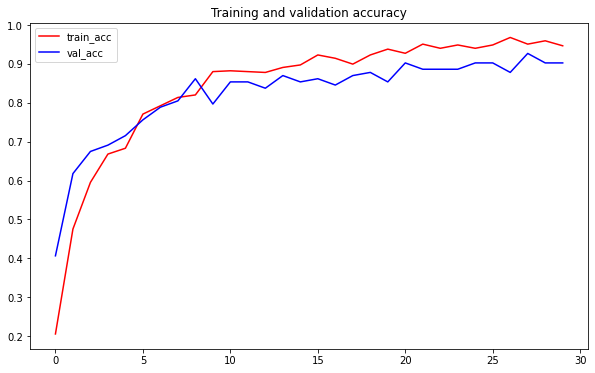

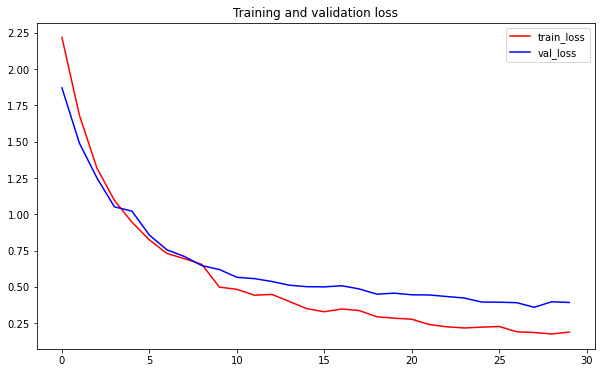

In [61]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

plt.figure(figsize=(10,6))
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,  acc,'r',label='train_acc' )
plt.plot  ( epochs, val_acc,'b',label='val_acc')
plt.title ('Training and validation accuracy')
plt.legend()
plt.show()
plt.figure(figsize=(10,6))
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,loss ,'r',label='train_loss')
plt.plot  ( epochs,val_loss,'b',label='val_loss' )
plt.title ('Training and validation loss'   )
plt.legend()

# 4. Save Model

In [ ]:
#Model_dir = 'Saved_model'
#version = 'tfLearning_Mobilenetv2_Koi'
#export_path = os.path.join(Model_dir,str(version))
#if os.path.isdir(export_path):
#    print('\nAlready saved a model, cleaning up\n')
#    !rm -r {export_path}

#model.save(export_path, save_format="tf")

In [ ]:
# In case if want to save it on HDF5 format
# model.save('model.h5')